In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [4]:
train_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
train_data = train_data.set_index('date')

In [6]:
train_data.index = pd.to_datetime(train_data.index)
train_data

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0
2013-01-01,1,1,BABY CARE,0.000,0
2013-01-01,2,1,BEAUTY,0.000,0
2013-01-01,3,1,BEVERAGES,0.000,0
2013-01-01,4,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


In [7]:
 len(train_data['family'].unique())

33

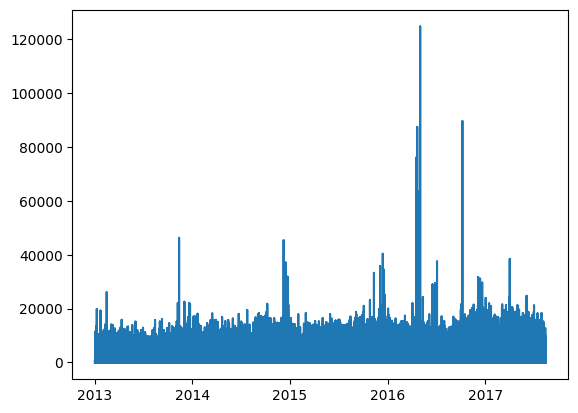

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_data.index , train_data['sales'] )
plt.show()

In [9]:
train_data.index.max() #Timestamp('2017-08-15 00:00:00')
train_data.index.min() #Timestamp('2013-01-01 00:00:00')
# it is daily data 

Timestamp('2013-01-01 00:00:00')

In [10]:
train_data.loc[train_data['sales'] < 0] 

,id,store_nbr,family,sales,onpromotion
date,,,,,


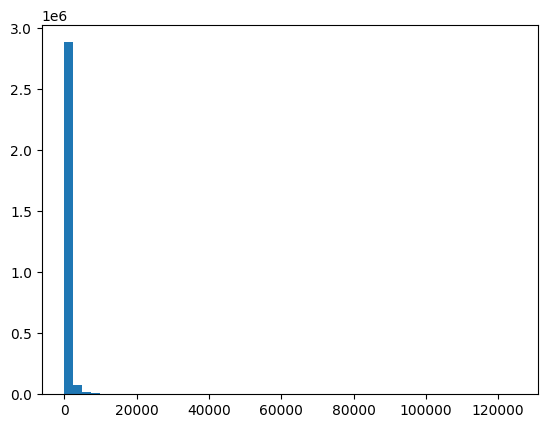

In [11]:
plt.hist(train_data['sales'] , bins=50)
plt.show()

In [12]:
train_data['family'].value_counts()

family
AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION          

In [13]:
train_data.isnull().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

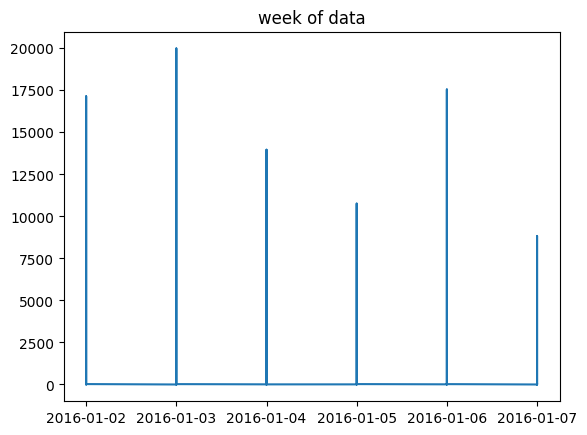

In [14]:
#visualize a week of data 
filtered_data = train_data[(train_data.index > '2016-01-01') & (train_data.index < "2016-01-08")]
plt.plot(filtered_data.index, filtered_data['sales'])
plt.title('week of data')
plt.show()


In [15]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['year'] = df.index.year
    df['month']  = df.index.month
#     df['weekofyear'] = df.index.weekofyear
    df['dayofyear'] = df.index.dayofyear
    df['day'] = df.index.day
    return df 
train_data_features = create_features(train_data)
train_data_features

,id,store_nbr,family,sales,onpromotion,dayofweek,year,month,dayofyear,day
date,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0,1,2013,1,1,1
2013-01-01,1,1,BABY CARE,0.000,0,1,2013,1,1,1
2013-01-01,2,1,BEAUTY,0.000,0,1,2013,1,1,1
2013-01-01,3,1,BEVERAGES,0.000,0,1,2013,1,1,1
2013-01-01,4,1,BOOKS,0.000,0,1,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0,1,2017,8,227,15
2017-08-15,3000884,9,PREPARED FOODS,154.553,1,1,2017,8,227,15
2017-08-15,3000885,9,PRODUCE,2419.729,148,1,2017,8,227,15


Text(0.5, 1.0, 'day')

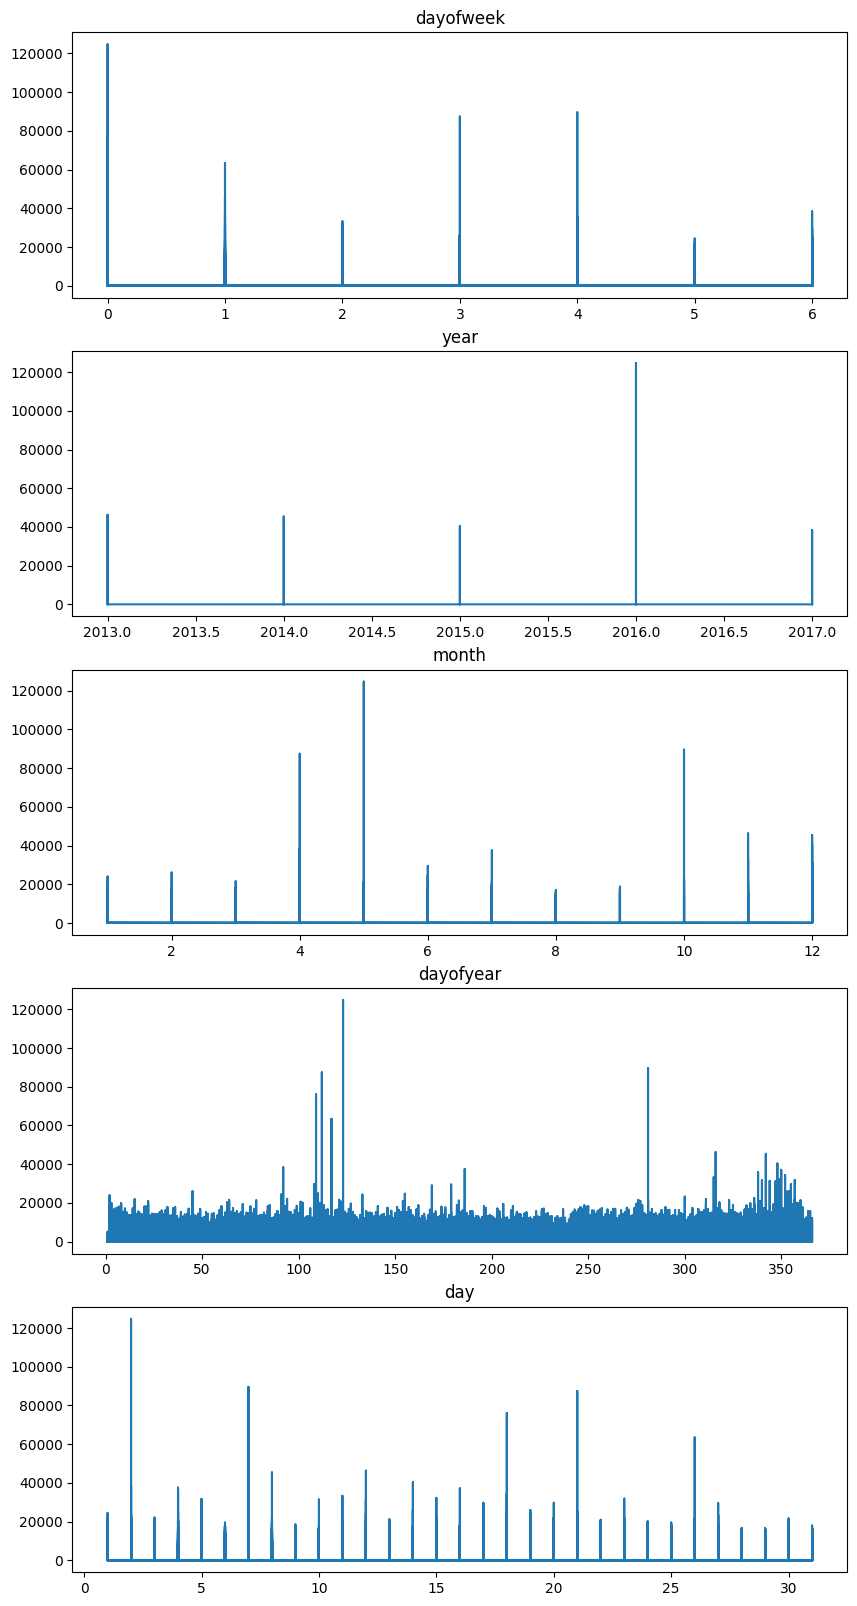

In [16]:
import matplotlib.pyplot as plt

fig , ax = plt.subplots( 5 ,1 , figsize=(10 , 20))
ax[0].plot(train_data_features['dayofweek'] , train_data_features['sales'])
ax[0].set_title('dayofweek')
ax[1].plot(train_data_features['year'] , train_data_features['sales'])
ax[1].set_title('year')
ax[2].plot(train_data_features['month'] , train_data_features['sales'])
ax[2].set_title('month')
ax[3].plot(train_data_features['dayofyear'] , train_data_features['sales'])
ax[3].set_title('dayofyear')
ax[4].plot(train_data_features['day'] , train_data_features['sales'])
ax[4].set_title('day')



Fold 0:
  Train: index=[     0      1      2 ... 500145 500146 500147]
  Test:  index=[ 500148  500149  500150 ... 1000293 1000294 1000295]
Fold 1:
  Train: index=[      0       1       2 ... 1000293 1000294 1000295]
  Test:  index=[1000296 1000297 1000298 ... 1500441 1500442 1500443]
Fold 2:
  Train: index=[      0       1       2 ... 1500441 1500442 1500443]
  Test:  index=[1500444 1500445 1500446 ... 2000589 2000590 2000591]
Fold 3:
  Train: index=[      0       1       2 ... 2000589 2000590 2000591]
  Test:  index=[2000592 2000593 2000594 ... 2500737 2500738 2500739]
Fold 4:
  Train: index=[      0       1       2 ... 2500737 2500738 2500739]
  Test:  index=[2500740 2500741 2500742 ... 3000885 3000886 3000887]


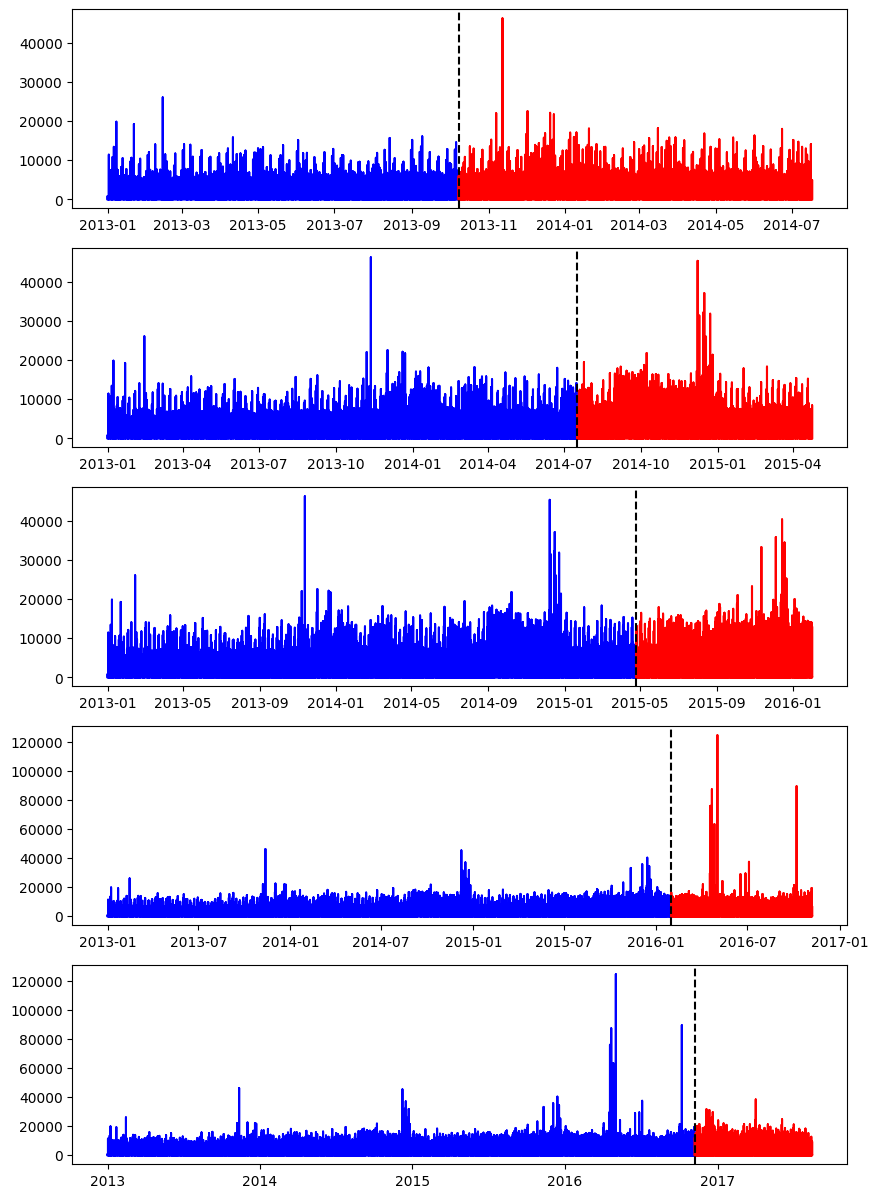

In [17]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
fig , ax = plt.subplots( 5 ,1 , figsize=(10 , 15) )
for i, (train_index, test_index) in enumerate(tss.split(train_data)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    train = train_data.iloc[train_index]
    test = train_data.iloc[test_index]
    ax[i].plot(train.index , train['sales'], color = 'b')
    ax[i].plot(test.index , test['sales'] , color = 'r')
    ax[i].axvline(test.index.min(), color='black', ls='--')

plt.show()

In [18]:
def add_lags_with_shift(df):
    df['lag1'] = df['sales'].shift(364)
    df['lag2'] = df['sales'].shift(728)
    df['lag3'] = df['sales'].shift(1092)
    return df
train_data = add_lags_with_shift(train_data)

In [19]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
train_data = train_data.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(train_data):
    train = train_data.iloc[train_idx]
    test = train_data.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'day', 'dayofweek', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'sales'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:09:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1153.13974	validation_1-rmse:1369.83402
[100]	validation_0-rmse:1067.53050	validation_1-rmse:1259.57625
[200]	validation_0-rmse:1045.54331	validation_1-rmse:1228.40797
[300]	validation_0-rmse:1034.43908	validation_1-rmse:1211.05803
[400]	validation_0-rmse:1025.89632	validation_1-rmse:1197.74453
[500]	validation_0-rmse:1019.21285	validation_1-rmse:1187.20716
[600]	validation_0-rmse:1014.77756	validation_1-rmse:1180.42395
[700]	validation_0-rmse:1011.37464	validation_1-rmse:1175.66574
[800]	validation_0-rmse:1008.02007	validation_1-rmse:1168.37074
[900]	validation_0-rmse:1004.55800	validation_1-rmse:1161.50367
[999]	validation_0-rmse:1001.14009	validation_1-rmse:1155.04210


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:12:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1153.87147	validation_1-rmse:1507.63336
[100]	validation_0-rmse:1068.16173	validation_1-rmse:1395.18583
[200]	validation_0-rmse:1046.22094	validation_1-rmse:1361.44784
[300]	validation_0-rmse:1034.93956	validation_1-rmse:1342.46005
[400]	validation_0-rmse:1026.33927	validation_1-rmse:1328.64666
[500]	validation_0-rmse:1019.82421	validation_1-rmse:1318.26989
[600]	validation_0-rmse:1015.02118	validation_1-rmse:1310.74428
[700]	validation_0-rmse:1011.51396	validation_1-rmse:1305.38781
[800]	validation_0-rmse:1008.23202	validation_1-rmse:1298.28872
[900]	validation_0-rmse:1005.14039	validation_1-rmse:1291.69320
[999]	validation_0-rmse:1001.82583	validation_1-rmse:1285.25566


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:16:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1155.06160	validation_1-rmse:1425.39250
[100]	validation_0-rmse:1069.22168	validation_1-rmse:1310.61096
[200]	validation_0-rmse:1047.16779	validation_1-rmse:1277.26782
[300]	validation_0-rmse:1036.12474	validation_1-rmse:1258.97314
[400]	validation_0-rmse:1027.35212	validation_1-rmse:1244.47747
[500]	validation_0-rmse:1020.98667	validation_1-rmse:1234.04988
[600]	validation_0-rmse:1016.55807	validation_1-rmse:1225.84237
[700]	validation_0-rmse:1013.04123	validation_1-rmse:1218.99440
[800]	validation_0-rmse:1009.70855	validation_1-rmse:1210.91036
[900]	validation_0-rmse:1006.18022	validation_1-rmse:1202.87350
[999]	validation_0-rmse:1002.80897	validation_1-rmse:1195.79366


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:19:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1155.95049	validation_1-rmse:1280.75708
[100]	validation_0-rmse:1069.92425	validation_1-rmse:1170.09275
[200]	validation_0-rmse:1047.69239	validation_1-rmse:1140.20837
[300]	validation_0-rmse:1036.51686	validation_1-rmse:1124.03919
[400]	validation_0-rmse:1027.91521	validation_1-rmse:1111.42597
[500]	validation_0-rmse:1021.36847	validation_1-rmse:1101.74127
[600]	validation_0-rmse:1016.55464	validation_1-rmse:1094.61426
[700]	validation_0-rmse:1013.16901	validation_1-rmse:1089.03149
[800]	validation_0-rmse:1009.78858	validation_1-rmse:1081.68513
[900]	validation_0-rmse:1006.32569	validation_1-rmse:1075.13134
[999]	validation_0-rmse:1002.89779	validation_1-rmse:1069.38266


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:22:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1156.33942	validation_1-rmse:1273.06292
[100]	validation_0-rmse:1070.22770	validation_1-rmse:1159.45091
[200]	validation_0-rmse:1048.07760	validation_1-rmse:1129.27238
[300]	validation_0-rmse:1036.79221	validation_1-rmse:1112.95799
[400]	validation_0-rmse:1027.95516	validation_1-rmse:1100.37024
[500]	validation_0-rmse:1021.42938	validation_1-rmse:1091.42915
[600]	validation_0-rmse:1016.88727	validation_1-rmse:1085.26325
[700]	validation_0-rmse:1013.38176	validation_1-rmse:1079.93088
[800]	validation_0-rmse:1010.11760	validation_1-rmse:1073.61891
[900]	validation_0-rmse:1006.76339	validation_1-rmse:1067.49953
[999]	validation_0-rmse:1003.62287	validation_1-rmse:1061.92958


In [20]:

print(f"fold scores : {scores}")
print(f'score across folds {np.mean(scores)}')

fold scores : [1155.0421029274091, 1285.2556618864876, 1195.7936584274219, 1069.3826629716561, 1061.9295730315587]
score across folds 1153.4807318489068


In [24]:
#retrain all the data
train_data =create_features(train_data)
FEATURES = ['dayofyear', 'day', 'dayofweek', 'month','year',
                'lag1','lag2','lag3']
TARGET = 'sales'
X_all = train_data[FEATURES]
y_all = train_data[TARGET]

reg = xgb.XGBRegressor(base_score=0.5 , booster='gbtree' , n_estimators=500 , objective='reg:linear' , max_depth=3,learning_rate=0.01)
reg.fit(X_all , y_all , eval_set=[(X_all , y_all)] , verbose=100)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:34:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1156.69324
[100]	validation_0-rmse:1070.42294
[200]	validation_0-rmse:1048.25454
[300]	validation_0-rmse:1036.98421
[400]	validation_0-rmse:1028.26160
[499]	validation_0-rmse:1021.58143


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [25]:
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
test_data

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [27]:
test_data.set_index('date' , inplace=True)
test_data

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0
...,...,...,...,...
2017-08-31,3029395,9,POULTRY,1
2017-08-31,3029396,9,PREPARED FOODS,0
2017-08-31,3029397,9,PRODUCE,1


In [29]:
test_data.index = pd.to_datetime(test_data.index)
test_data

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0
...,...,...,...,...
2017-08-31,3029395,9,POULTRY,1
2017-08-31,3029396,9,PREPARED FOODS,0
2017-08-31,3029397,9,PRODUCE,1


In [35]:
#concat the train and test data because of lag features
test_data['isfuture'] = True
train_data['isfuture'] = False
train_test_data = pd.concat([train_data , test_data])
train_test_data = create_features(train_test_data)
train_test_data = add_lags_with_shift(train_test_data)

In [36]:

train_test_data

,id,store_nbr,family,sales,onpromotion,lag1,lag2,lag3,dayofweek,year,month,dayofyear,day,isfuture
date,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,NaN,NaN,NaN,1,2013,1,1,1,False
2013-01-01,1,1,BABY CARE,0.0,0,NaN,NaN,NaN,1,2013,1,1,1,False
2013-01-01,2,1,BEAUTY,0.0,0,NaN,NaN,NaN,1,2013,1,1,1,False
2013-01-01,3,1,BEVERAGES,0.0,0,NaN,NaN,NaN,1,2013,1,1,1,False
2013-01-01,4,1,BOOKS,0.0,0,NaN,NaN,NaN,1,2013,1,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,NaN,1,NaN,NaN,NaN,3,2017,8,243,31,True
2017-08-31,3029396,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,3,2017,8,243,31,True
2017-08-31,3029397,9,PRODUCE,NaN,1,NaN,NaN,NaN,3,2017,8,243,31,True


In [37]:
test_data_w_features = train_test_data.loc[train_test_data['isfuture'] == True]
test_data_w_features

,id,store_nbr,family,sales,onpromotion,lag1,lag2,lag3,dayofweek,year,month,dayofyear,day,isfuture
date,,,,,,,,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,NaN,0,19.752,27.000,3322.75,2,2017,8,228,16,True
2017-08-16,3000889,1,BABY CARE,NaN,0,11.000,10.623,1.00,2,2017,8,228,16,True
2017-08-16,3000890,1,BEAUTY,NaN,2,0.000,3.000,12.00,2,2017,8,228,16,True
2017-08-16,3000891,1,BEVERAGES,NaN,20,26.000,0.000,5.00,2,2017,8,228,16,True
2017-08-16,3000892,1,BOOKS,NaN,0,5820.000,5.000,0.00,2,2017,8,228,16,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,NaN,1,NaN,NaN,NaN,3,2017,8,243,31,True
2017-08-31,3029396,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,3,2017,8,243,31,True
2017-08-31,3029397,9,PRODUCE,NaN,1,NaN,NaN,NaN,3,2017,8,243,31,True


In [38]:
test_data_w_features['pred'] = reg.predict(test_data_w_features[FEATURES])

/tmp/ipykernel_33/58023516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_w_features['pred'] = reg.predict(test_data_w_features[FEATURES])


In [39]:
test_data_w_features

,id,store_nbr,family,sales,onpromotion,lag1,lag2,lag3,dayofweek,year,month,dayofyear,day,isfuture,pred
date,,,,,,,,,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,NaN,0,19.752,27.000,3322.75,2,2017,8,228,16,True,22.992498
2017-08-16,3000889,1,BABY CARE,NaN,0,11.000,10.623,1.00,2,2017,8,228,16,True,262.903473
2017-08-16,3000890,1,BEAUTY,NaN,2,0.000,3.000,12.00,2,2017,8,228,16,True,250.095169
2017-08-16,3000891,1,BEVERAGES,NaN,20,26.000,0.000,5.00,2,2017,8,228,16,True,707.840210
2017-08-16,3000892,1,BOOKS,NaN,0,5820.000,5.000,0.00,2,2017,8,228,16,True,-84.082855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,NaN,1,NaN,NaN,NaN,3,2017,8,243,31,True,36.162086
2017-08-31,3029396,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,3,2017,8,243,31,True,36.162086
2017-08-31,3029397,9,PRODUCE,NaN,1,NaN,NaN,NaN,3,2017,8,243,31,True,36.162086


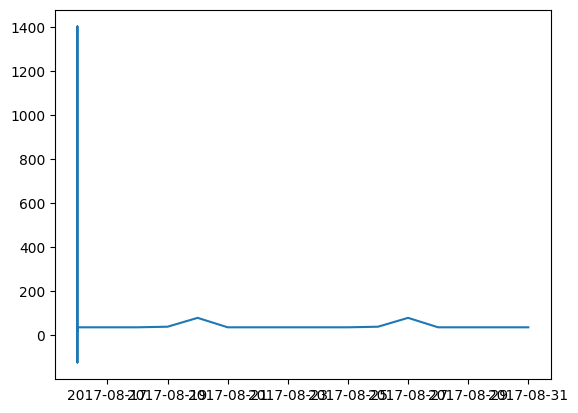

In [40]:
plt.plot(test_data_w_features.index , test_data_w_features['pred'])
plt.show()

In [44]:
final_test_data = pd.DataFrame({})
final_test_data['id'] = test_data['id']
final_test_data['sales'] = test_data_w_features['pred']
final_test_data

,id,sales
date,,
2017-08-16,3000888,22.992498
2017-08-16,3000889,262.903473
2017-08-16,3000890,250.095169
2017-08-16,3000891,707.840210
2017-08-16,3000892,-84.082855
...,...,...
2017-08-31,3029395,36.162086
2017-08-31,3029396,36.162086
2017-08-31,3029397,36.162086


In [53]:
final_test_data.reset_index()

,id,sales
0,3000888,22.992498
1,3000889,262.903473
2,3000890,250.095169
3,3000891,707.840210
4,3000892,-84.082855
...,...,...
28507,3029395,36.162086
28508,3029396,36.162086
28509,3029397,36.162086
28510,3029398,36.162086


In [56]:
final_test_data['id'] = test_data_w_features['id']
final_test_data.columns

ValueError: cannot reindex on an axis with duplicate labels

In [64]:
final_test_data.reset_index()

,id,sales
0,3000888,22.992498
1,3000889,262.903473
2,3000890,250.095169
3,3000891,707.840210
4,3000892,-84.082855
...,...,...
28507,3029395,36.162086
28508,3029396,36.162086
28509,3029397,36.162086
28510,3029398,36.162086


In [65]:
submission = final_test_data.to_csv('submission.csv' , index=False)